# Irgendwas stimmt derzeit mit min_connectivity nicht, für alle werte kommt dasselbe raus

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from model import CulturalModel
import pandas as pd

In [2]:
min_connectivity = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
all_runs_data = []

for mc_value in min_connectivity:
    model = CulturalModel(
        width=10,
        height=10,
        min_connectivity=mc_value,
        use_distance=True,
        difference_threshhold=0.4, # the higher the lower the interaction prob
        seed=42
    )
    
    for _ in range(50):
        model.step()
    run_data = model.datacollector.get_model_vars_dataframe()
    run_data['min_connectivity'] = mc_value
    run_data['Step'] = run_data.index
    all_runs_data.append(run_data)

final_combined_data = pd.concat(all_runs_data, ignore_index=True)

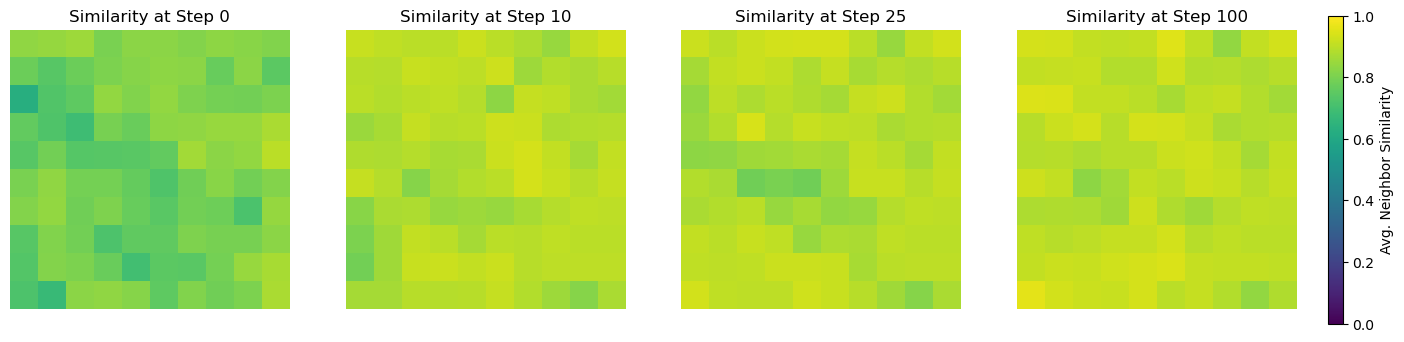

In [3]:
# Store similarity grids here
similarity_grids = []

model = CulturalModel(width=10, height=10, difference_threshhold=0.33, use_distance=True, seed=42, min_connectivity=0.3)

for step in range(101):
    model.step()
    similarity_grid = np.zeros((model.grid.width, model.grid.height))

    for agent in model.agents:
        x, y = agent.pos
        neighbors = model.grid.get_neighbors(agent.pos, moore=True, include_center=False)
        if not neighbors:
            similarity_grid[x][y] = 1.0  
            continue

        similarities = []
        for neighbor in neighbors:
            sim = sum(1 - abs(agent.culture[i] - neighbor.culture[i]) for i in range(5)) / 5
            similarities.append(sim)

        similarity_grid[x][y] = sum(similarities) / len(similarities)

    similarity_grids.append(similarity_grid.T)  


fig, axes = plt.subplots(1, 4, figsize=(20, 5))
steps_to_plot = [0, 10, 25, 100]

for i, step in enumerate(steps_to_plot):
    im = axes[i].imshow(similarity_grids[step], cmap='viridis', vmin=0, vmax=1)
    axes[i].set_title(f"Similarity at Step {step}")
    axes[i].axis('off')

cbar = fig.colorbar(im, ax=axes, location='right', shrink=0.8, pad=0.02)
cbar.set_label("Avg. Neighbor Similarity")

plt.show()

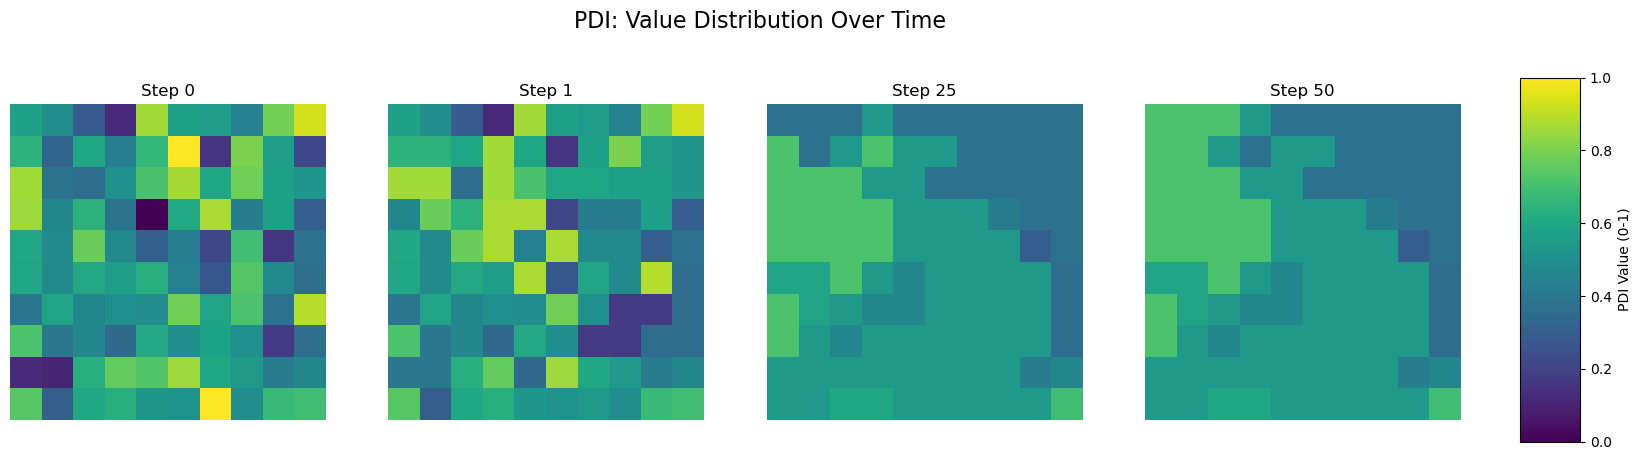

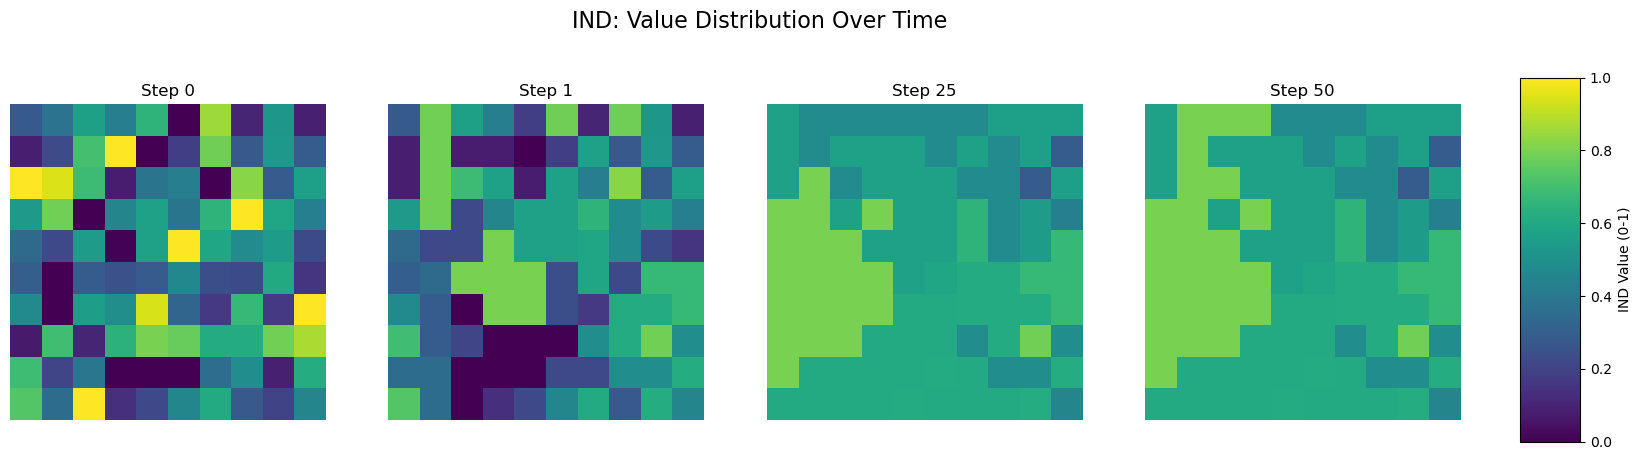

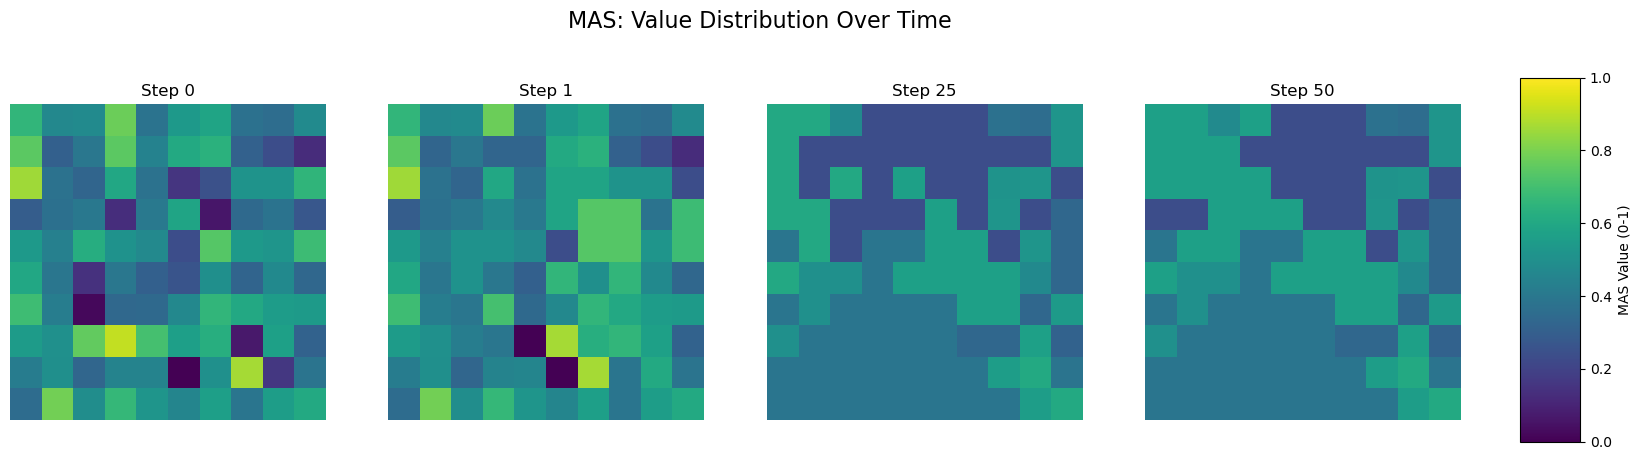

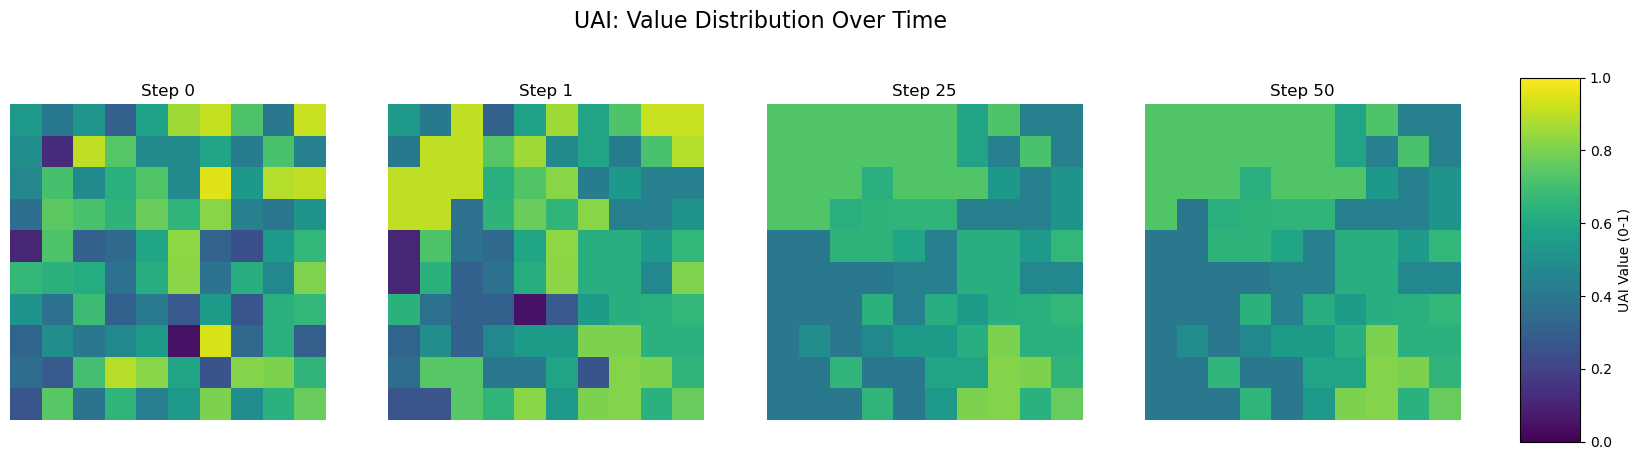

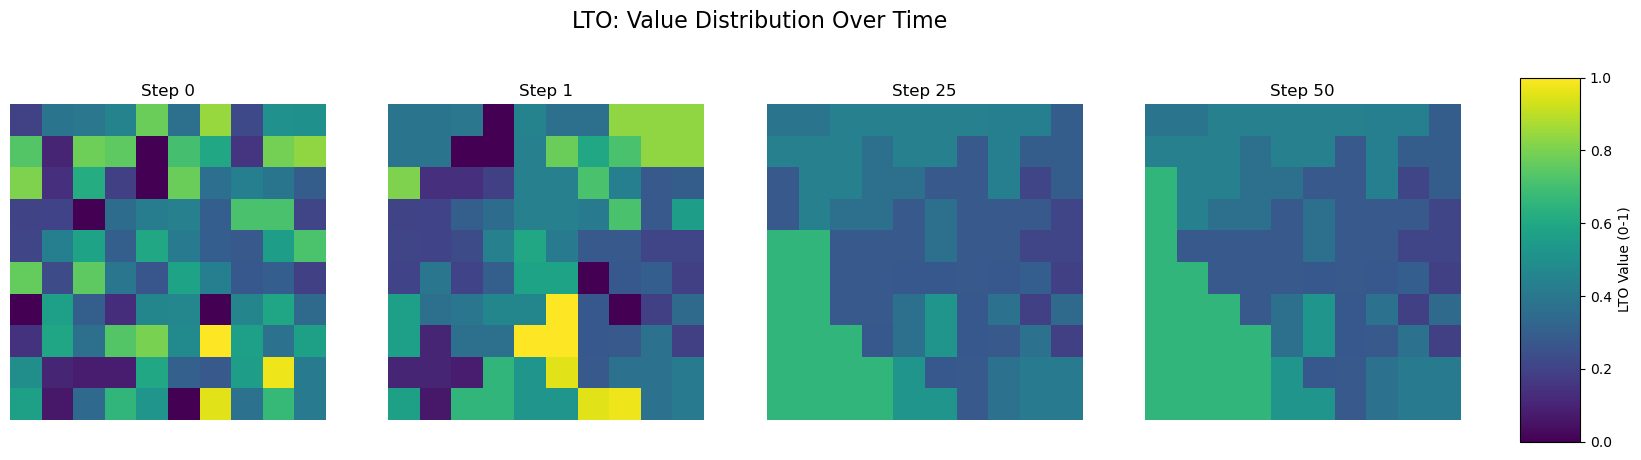

In [4]:
model = CulturalModel(
    width=10,
    height=10,
    min_connectivity=0.2, # Example value
    use_distance=True,
    difference_threshhold=0.3,
    seed=42
)

# Get dimension names and count from the model
dimension_names = [d_stat['name'] for d_stat in model.culture_dimension_stats]
num_dimensions = model.num_culture_dimensions

# --- Collect grids for ALL dimensions at different steps ---
# all_dimension_grids_over_time will be a list of "snapshots".
# Each "snapshot" will be a list of 2D numpy arrays (grids),
# where each grid corresponds to one cultural dimension.
# So, all_dimension_grids_over_time[snapshot_index][dimension_index]
all_dimension_grids_over_time = []
steps_to_snapshot = [0, 1, 25, 50] # Steps at which to save a snapshot (step 0 is initial state)
max_steps = 50 # Total steps to run the model

def get_all_dimension_grids_for_current_step(current_model):
    """Helper function to create a list of grids for all dimensions at current model state."""
    grids_for_this_snapshot = []
    for dim_idx in range(current_model.num_culture_dimensions):
        dimension_grid = np.full((current_model.grid.width, current_model.grid.height), np.nan) # Initialize with NaN
        if list(current_model.agents): # Check if agents exist
            for agent in current_model.agents:
                x, y = agent.pos
                if dim_idx < len(agent.culture):
                    dimension_grid[x][y] = agent.culture[dim_idx]
        grids_for_this_snapshot.append(dimension_grid.T) # Transpose for imshow
    return grids_for_this_snapshot

# Collect initial state (Step 0)
all_dimension_grids_over_time.append(get_all_dimension_grids_for_current_step(model))

# Run subsequent steps and collect snapshots
for step_num in range(1, max_steps + 1): # Start from step 1 up to max_steps
    model.step()
    if step_num in steps_to_snapshot:
        all_dimension_grids_over_time.append(get_all_dimension_grids_for_current_step(model))

# --- Plotting snapshots for EACH dimension ---
num_snapshot_occasions = len(steps_to_snapshot)

for dim_idx in range(num_dimensions):
    current_dimension_name = dimension_names[dim_idx]

    fig, axes = plt.subplots(1, num_snapshot_occasions, figsize=(5 * num_snapshot_occasions, 5.2))
    # If only one snapshot, axes might not be an array, ensure it is for consistent indexing
    if num_snapshot_occasions == 1:
        axes = np.array([axes])
    else:
        axes = axes.ravel() # Flatten if multiple snapshots (already 1D here, but good practice)

    # The `im` variable needs to be accessible for the colorbar,
    # so we'll get it from the last plotted image in the row.
    im = None

    for snapshot_idx, step_val in enumerate(steps_to_snapshot):
        # Retrieve the grid for the current dimension and current snapshot occasion
        # The `all_dimension_grids_over_time` list is ordered by when snapshots were taken.
        grid_to_plot = all_dimension_grids_over_time[snapshot_idx][dim_idx]

        ax = axes[snapshot_idx]
        im = ax.imshow(grid_to_plot, cmap='viridis', vmin=0, vmax=1) # Use 'viridis' or your preferred cmap
        ax.set_title(f"Step {step_val}")
        ax.axis('off')

    # Add a single colorbar for the current dimension's figure
    if im is not None: # Check if any image was actually plotted
        # Adjust subplot parameters to make space for the colorbar
        # The 'right' parameter controls how much space is left on the right of subplots
        fig.subplots_adjust(right=0.85, top=0.88) # Make space on right and for suptitle
        
        # Add a new axis for the colorbar
        # [left, bottom, width, height] in figure coordinates (0 to 1)
        cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7]) # Position to the right
        fig.colorbar(im, cax=cbar_ax, label=f"{current_dimension_name} Value (0-1)")
    else:
        fig.subplots_adjust(top=0.88)


    fig.suptitle(f"{current_dimension_name}: Value Distribution Over Time", fontsize=16)
    # plt.tight_layout() # tight_layout can sometimes conflict with manually added axes like cbar_ax.
                        # Using fig.subplots_adjust() provides more control here.

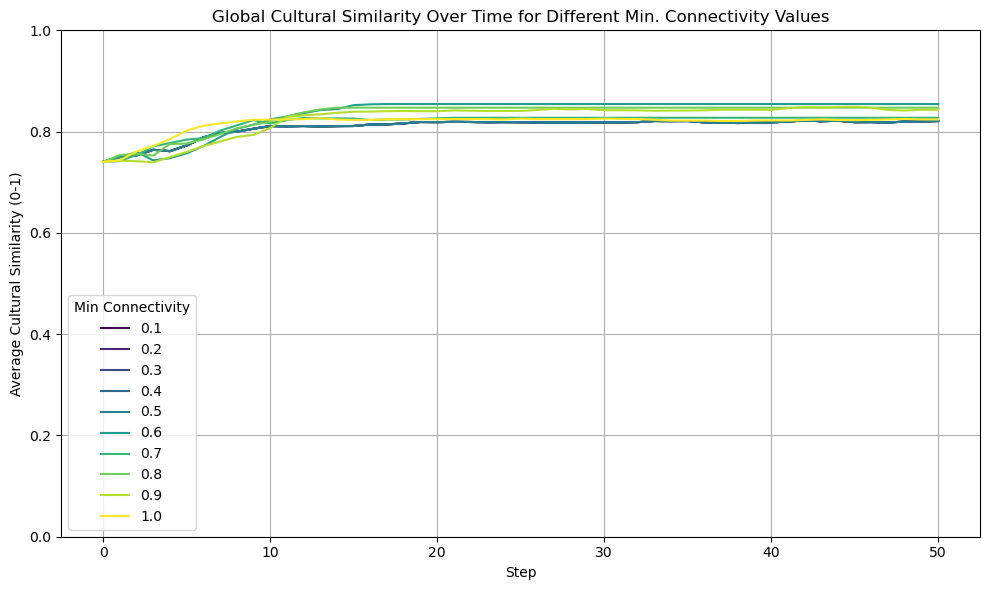

In [6]:
import seaborn as sns
# --- Plotting the combined data ---
plt.figure(figsize=(10, 6)) # Adjusted figure size slightly

# Using seaborn for easier plotting of multiple lines based on a category
# If you prefer pure matplotlib, you'd loop through unique 'min_connectivity' values
# and plot each one separately.
sns.lineplot(data=final_combined_data, x="Step", y="AverageCultureSimilarity", hue="min_connectivity", palette="viridis", legend="full")

plt.xlabel("Step")
plt.ylabel("Average Cultural Similarity (0-1)")
plt.title("Global Cultural Similarity Over Time for Different Min. Connectivity Values")
plt.grid(True)
plt.ylim(0, 1) # Ensure y-axis is between 0 and 1 for similarity
plt.legend(title="Min Connectivity") # Add legend title
plt.tight_layout()
plt.show()

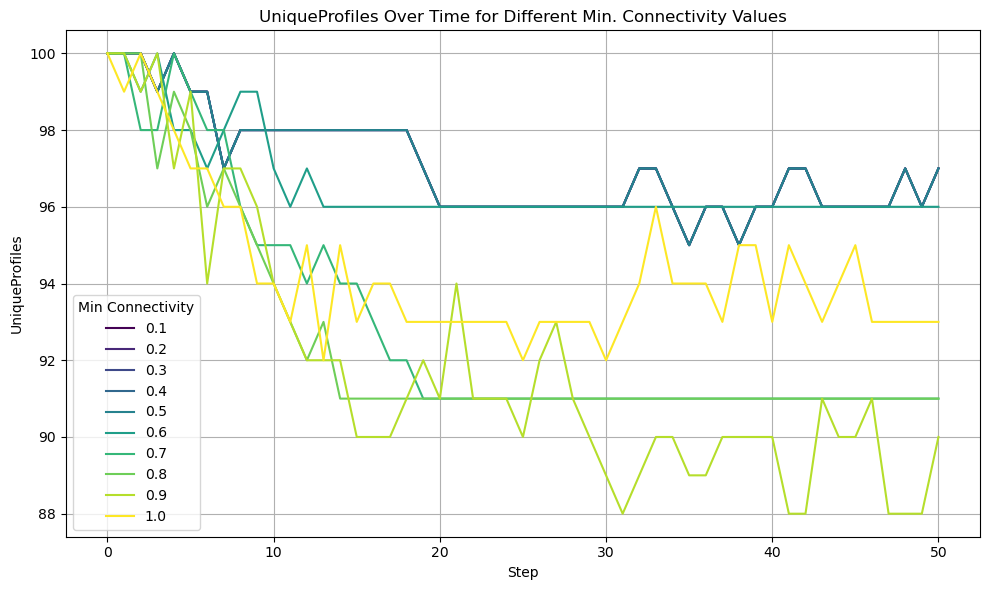

In [7]:
import seaborn as sns
# --- Plotting the combined data ---
plt.figure(figsize=(10, 6)) # Adjusted figure size slightly

# Using seaborn for easier plotting of multiple lines based on a category
# If you prefer pure matplotlib, you'd loop through unique 'min_connectivity' values
# and plot each one separately.
sns.lineplot(data=final_combined_data, x="Step", y="UniqueProfiles", hue="min_connectivity", palette="viridis", legend="full")

plt.xlabel("Step")
plt.ylabel("UniqueProfiles")
plt.title("UniqueProfiles Over Time for Different Min. Connectivity Values")
plt.grid(True)
plt.legend(title="Min Connectivity") # Add legend title
plt.tight_layout()
plt.show()


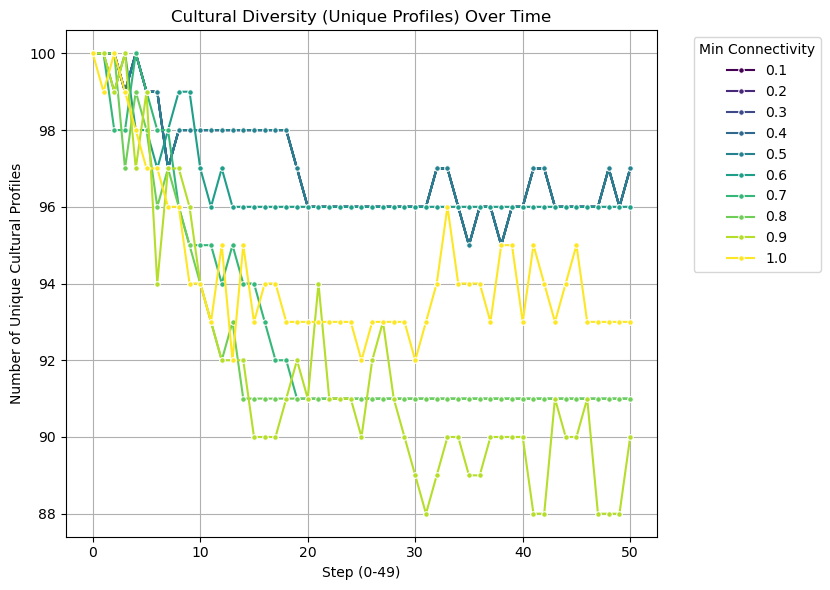

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported


# --- Corrected Plotting Code ---
plt.figure(figsize=(10, 6)) # Adjusted figure size for better legend placement

# Using seaborn for easier plotting of multiple lines based on a category
sns.lineplot(
    data=final_combined_data,
    x="Step",
    y="UniqueProfiles",
    hue="min_connectivity",
    palette="viridis", # Or any other palette you like
    legend="full",
    marker='o', # Optional: add markers
    markersize=4  # Optional: adjust marker size
)

plt.xlabel("Step (0-49)")
plt.ylabel("Number of Unique Cultural Profiles")
plt.title("Cultural Diversity (Unique Profiles) Over Time")
plt.grid(True)
# plt.ylim(bottom=0) # Optional: ensure y-axis starts at 0
plt.legend(title="Min Connectivity", bbox_to_anchor=(1.05, 1), loc='upper left') # Adjust legend position
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend if bbox_to_anchor is used
plt.show()

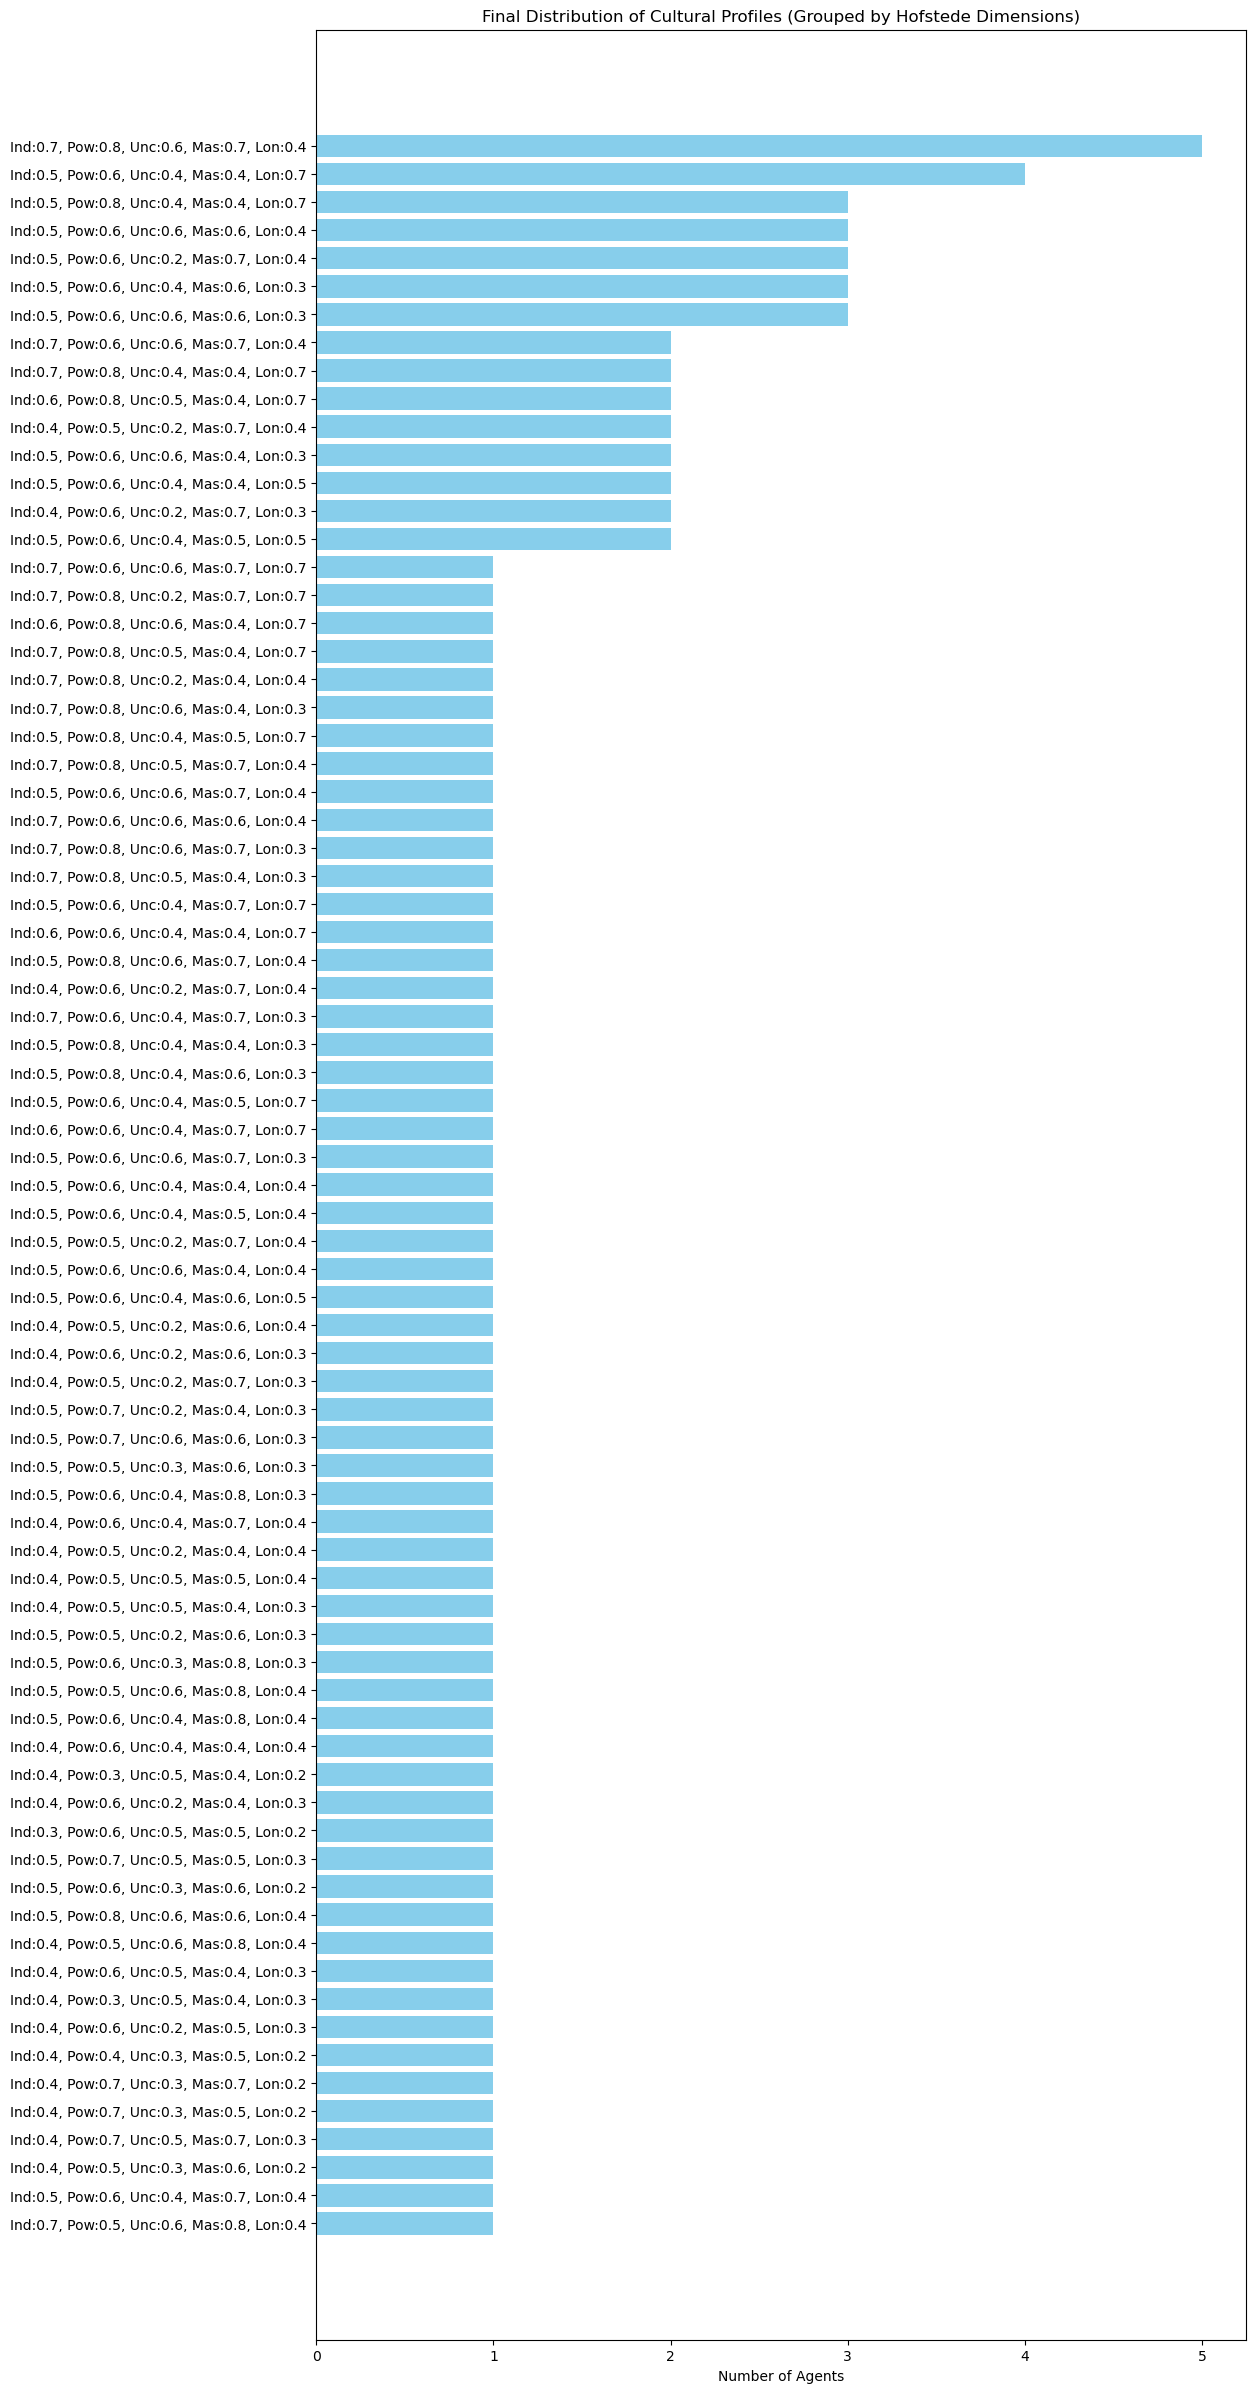

In [8]:
from collections import Counter

# Hofstede dimension names in order
hofstede_dims = [
    "Individualism", "Power Distance", "Uncertainty Avoidance",
    "Masculinity", "Long-Term Orientation", "Indulgence"
]

# Step 1: Count unique cultural profiles
profiles = [
    tuple(round(v, 1) for v in agent.culture)
    for agent in model.agents
]
profile_counts = Counter(profiles)

# Step 2: Sort by number of agents per profile
sorted_profiles = sorted(profile_counts.items(), key=lambda x: -x[1])

# Step 3: Convert tuples into readable labels
# Step 3: Shorter, single-line profile labels
labels = [
    ", ".join([f"{hofstede_dims[i][:3]}:{profile[i]}" for i in range(5)])
    for profile, _ in sorted_profiles]

values = [count for _, count in sorted_profiles]

# Step 4: Plot histogram
plt.figure(figsize=(12, max(4, len(labels) * 0.4)))  # dynamic height if many labels
plt.barh(labels, values, color='skyblue')
plt.xlabel("Number of Agents")
plt.title("Final Distribution of Cultural Profiles (Grouped by Hofstede Dimensions)")
plt.gca().invert_yaxis()
plt.show()


Cultural Type 0:
  Individualism: 0.4
  Power Distance: 0.53
  Uncertainty Avoidance: 0.4
  Masculinity: 0.46
  Long-Term Orientation: 0.3

Cultural Type 1:
  Individualism: 0.69
  Power Distance: 0.75
  Uncertainty Avoidance: 0.56
  Masculinity: 0.66
  Long-Term Orientation: 0.4

Cultural Type 2:
  Individualism: 0.58
  Power Distance: 0.7
  Uncertainty Avoidance: 0.4
  Masculinity: 0.46
  Long-Term Orientation: 0.62

Cultural Type 3:
  Individualism: 0.45
  Power Distance: 0.55
  Uncertainty Avoidance: 0.28
  Masculinity: 0.7
  Long-Term Orientation: 0.33

Cultural Type 4:
  Individualism: 0.54
  Power Distance: 0.6
  Uncertainty Avoidance: 0.52
  Masculinity: 0.62
  Long-Term Orientation: 0.33


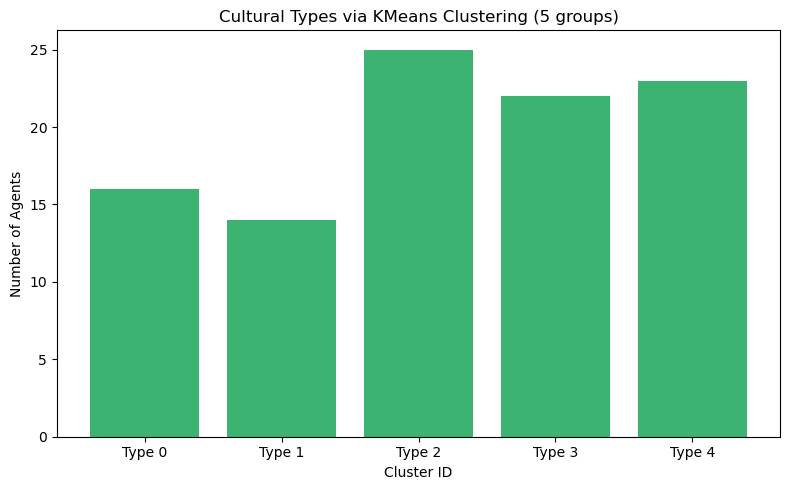

In [9]:
from sklearn.cluster import KMeans

# Step 1: Collect all agent culture vectors
X = np.array([agent.culture for agent in model.agents])

# Step 2: Choose number of clusters (e.g., 4–6 for interpretability)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Step 3: Count agents in each cluster
counts = np.bincount(cluster_labels)

for i, center in enumerate(kmeans.cluster_centers_):
    print(f"\nCultural Type {i}:")
    for dim, value in zip(hofstede_dims, center):
        print(f"  {dim}: {round(value, 2)}")

# Step 4: Plot results
plt.figure(figsize=(8, 5))
plt.bar(range(n_clusters), counts, color='mediumseagreen')
plt.xlabel("Cluster ID")
plt.ylabel("Number of Agents")
plt.title(f"Cultural Types via KMeans Clustering ({n_clusters} groups)")
plt.xticks(range(n_clusters), [f"Type {i}" for i in range(n_clusters)])
plt.tight_layout()
plt.show()